In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.patheffects as pe

In [22]:
from scipy.interpolate import CubicSpline

In [35]:
df = pd.read_csv("Polar_Graph_1.csv", header=0)
df

df1 = df.iloc[:, [0, 1]].apply(pd.to_numeric, errors='coerce').dropna()
df2 = df.iloc[:, [3, 4]].apply(pd.to_numeric, errors='coerce').dropna()
df3 = df.iloc[:, [6, 7]].apply(pd.to_numeric, errors='coerce').dropna()
df4 = df.iloc[:, [9, 10]].apply(pd.to_numeric, errors='coerce').dropna()

In [43]:
df1.iloc[:, 1].name

'T1_Re30.000_M0.20_N9.0'

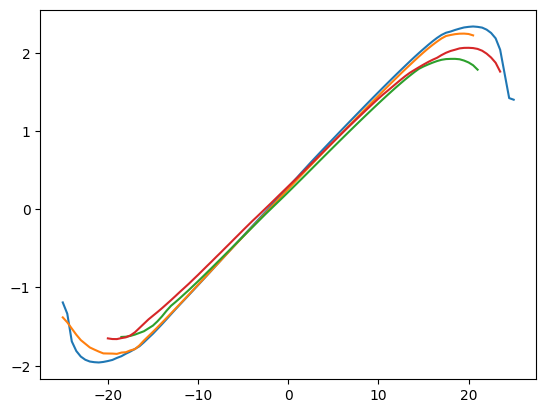

In [34]:
plt.plot(df1['Alpha'], df1['Cl'])
plt.plot(df2['Alpha'], df2['Cl'])
plt.plot(df3['Alpha'], df3['Cl'])
plt.plot(df4['Alpha'], df4['Cl'])

In [24]:
df2

,Alpha2,Cl2
0,-24.5,-1.445509
1,-24.0,-1.524983
2,-23.5,-1.603516
3,-23.0,-1.672528
4,-22.0,-1.766261
...,...,...
82,18.5,2.236830
83,19.0,2.242833
84,19.5,2.243957
85,20.0,2.238972


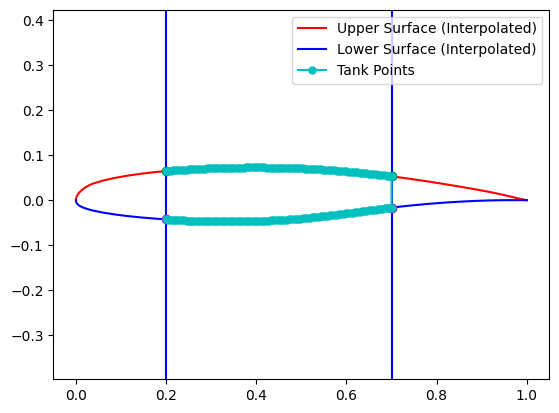

(0.04802976055728112,
 0.05362505675734594,
 0.053222712712410636,
 0.054553112073745164)

In [19]:
def plot_airfoil_with_c(airfoil, c, plot = False):
    f, b = 0.2 * c, 0.7 * c
    x_lines = [f, b]

    x, y = airfoil.x * c, airfoil.y * c
    te_index = np.argmin(x)

    x_upper = np.array(list(reversed(x[:te_index + 1])))
    y_upper = np.array(list(reversed(y[:te_index + 1])))

    x_lower = x[te_index:]
    y_lower = y[te_index:]

    cs_upper = CubicSpline(x_upper, y_upper)
    cs_lower = CubicSpline(x_lower, y_lower)

    def find_intersection(x_line):
        # Check if the x-line is in the upper or lower surface
        if x_line <= np.max(x_upper):
            y_line_upper = cs_upper(x_line)
        else:
            y_line_upper = None

        if x_line >= np.min(x_lower):
            y_line_lower = cs_lower(x_line)
        else:
            y_line_lower = None

        return y_line_upper, y_line_lower
    
    intersections = [find_intersection(x) for x in x_lines]

    upper_coords = np.linspace(x_lines[0], x_lines[1], 100)
    lower_coords = np.linspace(x_lines[1], x_lines[0], 100)

    polygon_points = np.vstack([
        np.column_stack([upper_coords, cs_upper(upper_coords)]), 
        np.column_stack([lower_coords, cs_lower(lower_coords)])  
    ])

    if plot:
        plt.plot(x_upper, cs_upper(x_upper), 'r-', label='Upper Surface (Interpolated)')
        plt.plot(x_lower, cs_lower(x_lower), 'b-', label='Lower Surface (Interpolated)')

        for i, x in enumerate(x_lines):
            y_upper, y_lower = intersections[i]
            plt.axvline(x=x, color='blue')
            if y_upper is not None:
                plt.plot(x, y_upper, 'go')  # Intersection on upper surface
            if y_lower is not None:
                plt.plot(x, y_lower, 'mo')  # Intersection on lower surface
            #print(x)

        plt.plot(polygon_points[:, 0], polygon_points[:, 1], 'co-', label='Tank Points', markersize=5)

    def shoelace_area(points):
        x = points[:, 0]
        y = points[:, 1]
        return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
    
    area = shoelace_area(polygon_points)
    #print(f"Approximate area using shoelace formula with high-point polygon: {area:.4f} m^2")
    if plot:
        plt.axis('equal')
        plt.legend()
        plt.show()
    return area

npl = pd.read_table("npl9510.dat", sep='\s+', skiprows=[0], names=['x','y'], index_col=False)
rae28 = pd.read_table("rae2822.dat", sep='\s+', skiprows=[0], names=['x','y'], index_col=False)
rae52 = pd.read_table("rae5212.dat", sep='\s+', skiprows=[0], names=['x','y'], index_col=False)
sc2 = pd.read_table("sc(2)-0412.dat", sep='\s+', skiprows=[0], names=['x','y'], index_col=False)

plot_airfoil_with_c(npl, c=1), plot_airfoil_with_c(rae28, c=1), plot_airfoil_with_c(rae52, c=1, plot=True), plot_airfoil_with_c(sc2, c=1)

# plot_airfoil_with_c(data, c=3)


In [15]:
b = 55.98 # np.sqrt(410 * 10)

volume = 0
dl = 0.1
for y in np.arange(0, b/2, dl):
    c = 9.16 * ((0.3 - 1) / (b/2) * y + 1)
    volume += plot_airfoil_with_c(rae52, c) * dl
volume *= 2
volume

116.2429593504487

In [16]:
775 * volume,  840 * volume

(90088.29349659775, 97644.08585437691)